# Reading the data

In [60]:
# basic imports
import csv
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from gurobipy import *
import cvxpy as cvx

# scikit learn
from sklearn import linear_model
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn import svm
from sklearn import cross_validation
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [2]:
# reading CSV file
reader = csv.reader(open('features_2.csv', 'r'), delimiter=',')
data_full = np.array(list(reader))
reader = csv.reader(open('all_endpoints_with_missing_values_012615.csv', 'r'), delimiter=',')
activity_full = np.array(list(reader))

In [3]:
# feature names
feature_names = data_full[0, 1:]

# names of the proteins
protein_names = data_full[1:, 0]
protein_names1 = activity_full[1:, 0]
print 'Protein names equality check:', np.array_equal(protein_names1, protein_names)

# names of receptors
receptor_names = activity_full[0, 1:]

# Object-Feature matrix (proteins description)
X = data_full[1:, 1:].astype('double')

# Activity matrix
Y = activity_full[1:, 1:].astype('int16')

# Removing constant features
ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

# Number of features
N = X.shape[1]

Protein names equality check: True


In [4]:
print receptor_names

['NR-AhR' 'NR-AR-LBD' 'NR-AR' 'SR-MMP' 'NR-ER' 'SR-HSE' 'SR-p53'
 'NR-PPAR-gamma' 'SR-ARE' 'NR-Aromatase' 'SR-ATAD5' 'NR-ER-LBD']


In [5]:
Y = Y[:, 0:3]
ind = np.all(Y != 999, axis=1)
X = X[ind]
Y = Y[ind]

ind = np.var(X, axis = 0) != 0
X = X[:, ind]
feature_names = feature_names[ind]

n = X.shape[1]
m = Y.shape[1]
print X.shape

(4282L, 165L)


# Feature selection

## Counting importances of the features and correlation matrix

In [6]:
data_norm = preprocessing.scale(X)
costs = np.zeros(n)
for i in range(n):
    data = X[:,i].reshape((X.shape[0], 1))
    LR = linear_model.LogisticRegression()  
    scores = cross_validation.cross_val_score(LR, data, Y[:, 0], cv=5, scoring='roc_auc')
    costs[i] = scores.mean()

In [7]:
e = np.corrcoef(data_norm.T)
w = costs

## Greedy algorithm with importances

In [8]:
def select_features(t, e):
    global costs
    S = []
    c = 0.1
    ind = range(n)
    opt = []
    w = np.copy(costs)
    for i in range(t):
        f = np.argmax(w)
        w[f] = -np.inf
        for j in range(n):
            w[j] = w[j] - e[f, j]*2*c
        opt.append(ind[f])
    return opt

In [11]:
auc_greedy = []
for t in range(1, 160):
    opt = select_features(t, e)
    X_new = data_norm[:, opt]
    SVM = svm.SVC()  
    scores = cross_validation.cross_val_score(SVM, X_new, Y[:, 0], cv=5, scoring='roc_auc')
    auc_greedy.append(scores.mean()) 

158


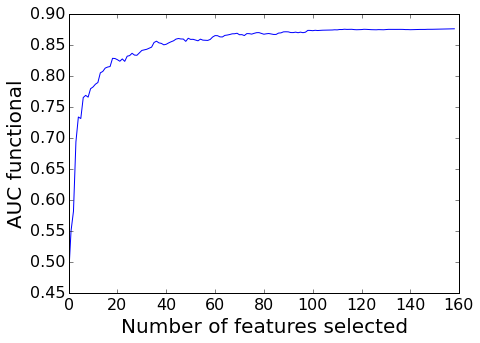

In [14]:
plt.rcParams.update({'font.size': 16})
plt.figure(figsize=(7, 5))
plt.xlabel('Number of features selected',  fontsize=20,)
plt.ylabel('AUC functional',  fontsize=20)
plt.plot(auc_greedy)
print np.argmax(auc_greedy)

## Solving the problem with cvxpy non integer solver

In [16]:
auc2 = []
er2 = []
er22 = []
for k in range(1,160):
    e = np.abs(np.corrcoef(data_norm.T))
    np.fill_diagonal(e, 0)
    e = e.dot(e.T)
    w = 5*n*costs
    #x = cvx.Bool(n)
    x = cvx.Variable(n)
    obj = cvx.Maximize(w*x + cvx.quad_form(x, -e))
    constraints = [x >= 0, x<= 1, sum(x) == k]
    prob = cvx.Problem(obj, constraints)
    prob.solve()
    #prob.solve()
    ans = np.array([np.array(x.value) > 0.2]).reshape(n)
    X_new = data_norm[:, ans]
    SVM = svm.SVC()  
    scores = cross_validation.cross_val_score(SVM, X_new, Y[:, 0], cv=5, scoring='roc_auc')
    auc2.append(scores.mean())
    er2.append(prob.value)
    er22.append(np.inner(w, ans) - e.dot(ans).T.dot(ans))
    

In [17]:
ans = np.array([np.array(x.value) > 0.2], dtype='bool')
ans = ans.reshape(n)

In [18]:
X_new = data_norm[:, ans]
SVM = svm.SVC()  
scores = cross_validation.cross_val_score(SVM, X_new, Y[:, 0], cv=5, scoring='roc_auc')

In [19]:
print scores.mean()

0.875873980245


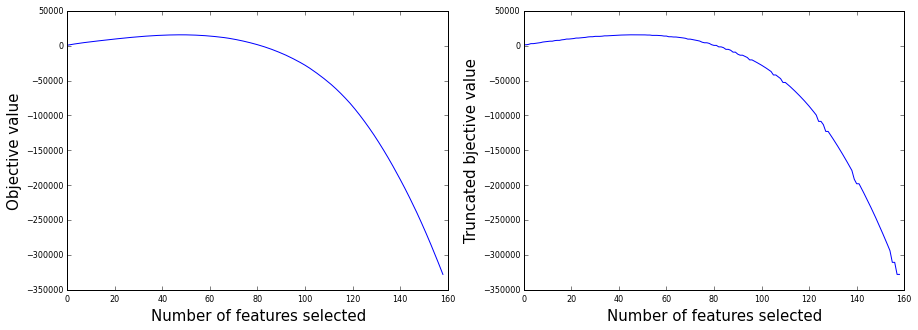

In [28]:
plt.rcParams.update({'font.size': 8})
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlabel('Number of features selected',  fontsize=15)
axes[0].set_ylabel('Objective value',  fontsize=15)
axes[0].plot(er2)
axes[1].set_xlabel('Number of features selected',  fontsize=15,)
axes[1].set_ylabel('Truncated objective value',  fontsize=15)
axes[1].plot(er22)
plt.show()

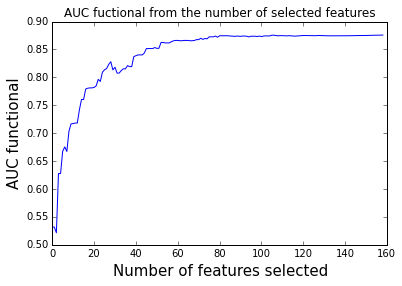

In [41]:
plt.rcParams.update({'font.size': 10})
plt.ylabel('AUC functional',  fontsize=15)
plt.xlabel('Number of features selected',  fontsize=15)
plt.title('AUC fuctional from the number of selected features')
plt.plot(auc2)
plt.show()

## Solving the problem with gurobi integer solver

In [31]:
auc3 = []
er3 = []
for k in range(1,160):
    e = np.abs(np.corrcoef(data_norm.T))
    np.fill_diagonal(e, 0)
    e = e.dot(e.T)
    w = 5*n*costs
    x = cvx.Bool(n)
    obj = cvx.Maximize(w*x + cvx.quad_form(x, -e))
    constraints = [x >= 0, x<= 1, sum(x) == k]
    prob = cvx.Problem(obj, constraints)
    prob.solve(solver = 'GUROBI')
    ans = np.array(x.value, dtype = 'bool').reshape(n)
    X_new = data_norm[:, ans]
    SVM = svm.SVC()  
    scores = cross_validation.cross_val_score(SVM, X_new, Y[:, 0], cv=5, scoring='roc_auc')
    auc3.append(scores.mean())
    er3.append(prob.value)

In [33]:
ans = np.array(x.value, dtype = 'bool')
ans = ans.reshape(n)

X_new = data_norm[:, ans]
SVM = svm.SVC()  
scores = cross_validation.cross_val_score(SVM, X_new, Y[:, 0], cv=5, scoring='roc_auc')
print scores.mean()

0.875873980245


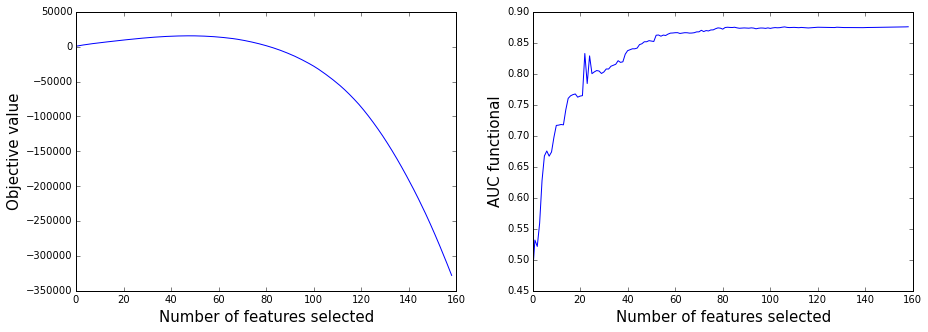

In [40]:
plt.rcParams.update({'font.size': 10})
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(15,5))
axes[0].set_xlabel('Number of features selected',  fontsize=15)
axes[0].set_ylabel('Objective value',  fontsize=15)
axes[0].plot(er3)
axes[1].set_xlabel('Number of features selected',  fontsize=15,)
axes[1].set_ylabel('AUC functional',  fontsize=15)
axes[1].plot(auc3)
plt.show()

## Mincut-Maxflow formulation

In [35]:
c = 1
e = np.abs(np.corrcoef(data_norm.T))
e1 = 1 - e
costs = costs - min(costs)
costs = costs/max(costs)
e1[np.where(e1 > 0.2)] = 0
np.fill_diagonal(e1, 0)
u = c*(costs - 1.0) + np.sum(e1, axis = 0)
u_pairwise = -e1/2
x = cvx.Variable(n)
constraints = [x >= 0, x<= 1]
s = 0
for i in range(n):
    for j in range(n):
        s += u_pairwise[i,j]*cvx.abs(x[i] - x[j])
obj = cvx.Maximize(u*x + s)
prob = cvx.Problem(obj, constraints)
prob.solve()

print prob.status

optimal


In [36]:
ans = np.array(np.array(x.value) > 0.1).reshape(n)
print 'Initial objective:', prob.value
print 'Truncated objective:', (costs-1).dot(ans) + ans.T.dot(e1).dot(ans)
print 'Number of selected features:', sum(ans)

Initial objective: 159.908099643
Truncated objective: 159.908099644
Number of selected features: 85


## Greedy algorithm with stability criteria

In [42]:
print 'Number of proteins is', X.shape[0], ', number of features is', X.shape[1]
print 'Number of nuclear receptors:', Y.shape[1]
print 'Fully observed cases (no 999 values in corresponding Y row):', np.sum(np.all(Y != 999, axis=1))
print 'Matrix rank:', np.linalg.matrix_rank(X)
print 'Matrix condition number:', np.linalg.cond(X)

Number of proteins is 4282 , number of features is 165
Number of nuclear receptors: 3
Fully observed cases (no 999 values in corresponding Y row): 4282
Matrix rank: 158
Matrix condition number: 6.63384682382e+20


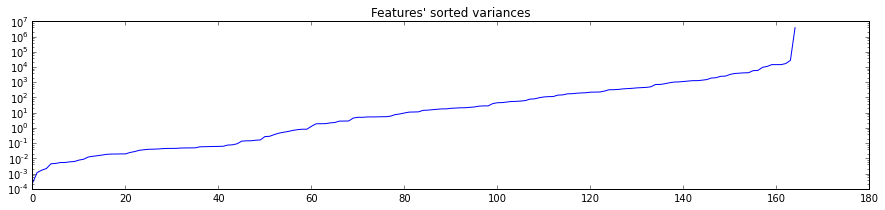

In [43]:
variances =  np.sort(np.var(X, axis = 0))
plt.figure(figsize=(15, 3))
plt.semilogy(variances)
plt.title('Features\' sorted variances')
plt.show()

b_single


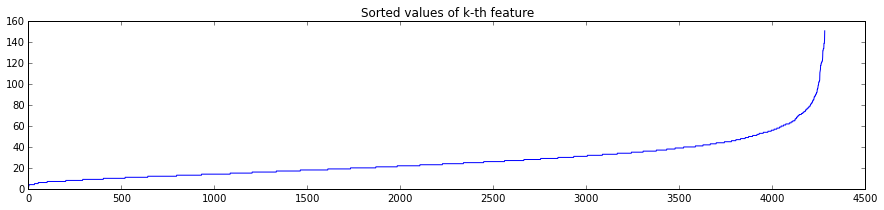

In [46]:
# index of feature with k-th smallest variance
k = 0
ifeature = np.argsort(np.var(X, axis=0))[k]
ifeature = np.where(feature_names == 'b_single')[0][0]
# 'a_count' 'GCUT_PEOE_1' 'TPSA' 'vsa_hyd' 'lip_acc' 'a_nH' 'vsa_pol'
# 'PEOE_VSA_HYD' 'GCUT_SLOGP_1' 'chi0v_C' 'PEOE_VSA_POL' 'apol'
# 'GCUT_PEOE_2' 'b_count' 'PEOE_VSA_FHYD' 'vdw_vol' 'PEOE_VSA_FPOL'
# 'PEOE_PC-' 'b_single' 'PEOE_PC+'

print feature_names[ifeature]
plt.figure(figsize=(15, 3))
plt.plot(np.sort(X[:, ifeature]))
plt.title('Sorted values of k-th feature')
plt.show()

In [47]:
X = preprocessing.scale(X, axis = 0)

In [48]:
# 2-class classification for nuclear receptor number i_nuclear
def two_class_ROC(X, Y, i_nuclear):
    # take only those proteins, for which we know activity with i_nuclear
    ind = np.where(Y[:, i_nuclear]  != 999)

    X_train, X_test, y_train, y_test = cross_validation.train_test_split(
        X[ind], Y[ind, i_nuclear][0], test_size=0.2, random_state=0)

    model = LinearRegression().fit(X_train, y_train)
    predict = model.predict(X_test)
    
    AUC = roc_auc_score(y_test, predict)
    fpr, tpr, _ = roc_curve(y_test, predict)
    return AUC, fpr, tpr

In [58]:
def eliminate_feature(X):
    # singular value decompisition of matrix X^T X
    U, S, V = np.linalg.svd(X.T.dot(X))
    V = V.T
    k = len(S)
    
    # phi[i, l] = v[i,l]^2/s[l,l]
    phi = V ** 2 / np.repeat(S, k).reshape(k, k).T
    
    # pi[i, l] = phi[l, i] / sum(phi[l, :])
    pi = phi.T
    pi = pi/np.sum(pi, axis=0)
    
    # smallest singular value is S[k] as they are sorted
    l = k-1
    i = np.argsort(pi[l, :])[-1]
    
    return np.delete(X, i, axis=1), i

def Belsley_feature_selection(X, feature_names):
    # here we copy X and will further delete columns from X_new
    X_new = X
    # array of condition numbers of ontained matrices
    cond_n = []
    # numbers of features, which were deleted
    deleted_features = []
    # features which are still present
    current_features = np.array(range(X.shape[1]))
    # best subset of features
    best_features = current_features
    AUC_best = 0
    
    AUCs = []
    
    while np.linalg.cond(X_new) > 1.2:
        cond_n.append(np.linalg.cond(X_new))

        AUC_new = two_class_ROC(X_new, Y, i_nuclear=1)[0]
        AUCs.append(AUC_new)
        if AUC_new > AUC_best:
            AUC_best = AUC_new
            best_features = current_features[:]
        
        X_new, i = eliminate_feature(X_new)
        deleted_features.append(current_features[i])
        current_features = np.delete(current_features, i)

    X_new = X[:, best_features]
    feature_names_new = feature_names[best_features]
    cond_n = np.array(cond_n)
    deleted_features = np.array(deleted_features)
    AUCs = np.array(AUCs)
    return X_new, feature_names_new, cond_n, deleted_features, AUCs
    

In [61]:
X_new, feature_names_new, cond_n, deleted_features, AUCs = Belsley_feature_selection(X, feature_names)

In [79]:
def plot_AUCs(AUCs):
    plt.rcParams.update({'font.size': 10})
    plt.figure(figsize=(7, 5))
    plt.plot(range(X.shape[1], X.shape[1]-len(AUCs), -1), AUCs, color='blue')
    plt.xlabel('Number of selected features', fontsize=15)
    plt.xlim(X.shape[1], X.shape[1]-len(AUCs))
    plt.title('AUC dependence on number of selected features', fontsize=15)
    plt.ylabel('AUC')
    #plt.ylim(0, 1)

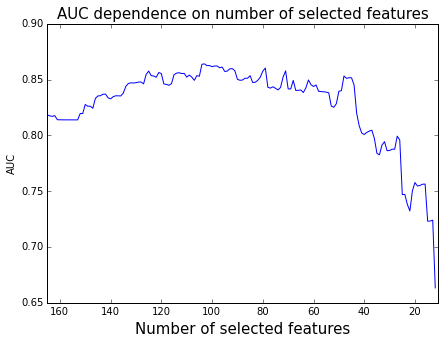

In [80]:
plot_AUCs(AUCs)

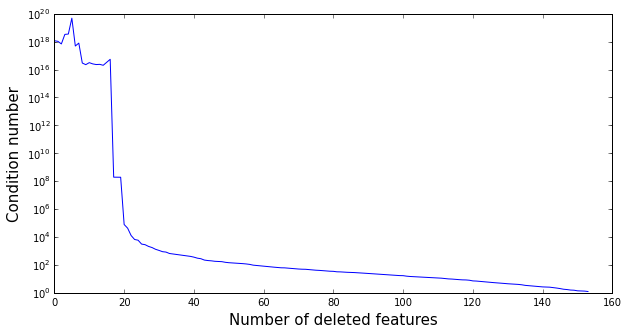

In [78]:
plt.rcParams.update({'font.size': 10})
plt.figure(figsize=(10, 5))
plt.semilogy(cond_n)
#plt.set_ylim(1e0, 1e40)
plt.xlabel('Number of deleted features', fontsize=15)
plt.ylabel('Condition number', fontsize=15)
plt.show()